In [1]:
import os
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from matplotlib import pyplot as plt


2024-05-27 21:20:37.612062: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("data.csv")
df.head()

,Loan_ID,Borrower_Credit_Score,Debt_to_Income_Ratio,Loan_to_Value_Ratio,Annual_Income,Loan_Amount,Loan_Term_Years,Collateral_Value,Industry_Sector,Credit_History_Length_Years,Past_Due_Payments,Consumer_Confidence_Index,Business_Confidence_Index,Inflation_Rate,GDP_Growth_Rate,Loan_Type,Credit_Rating
0,1,402,0.398315,1.106749,78675.977640,414104.460635,21,917686.252666,Energy,7,6,0.854231,0.644061,0.958277,0.085511,Corporate,Caa
1,2,735,0.143431,0.683775,124060.378227,385719.368020,10,656265.208167,Consumer Goods,1,0,0.170552,0.070020,0.087049,0.522579,Government,Ba
2,3,570,0.450857,0.620635,127256.306107,141940.043984,20,381989.233612,Technology,25,1,0.401120,0.870602,0.550757,0.388916,Personal,B
3,4,406,0.126321,0.512612,137110.099138,106869.794705,17,623333.198930,Technology,12,0,0.459856,0.807807,0.026187,0.912981,Personal,B
4,5,371,0.129654,0.565705,172010.073337,132948.271082,20,366727.737377,Consumer Goods,1,8,0.480876,0.006936,0.903385,0.301710,Corporate,B


In [3]:
# Encode the Industry_Sector
sector_mapping = {sector: idx for idx, sector in enumerate(df['Industry_Sector'].unique())}
df['Industry_Sector'] = df['Industry_Sector'].map(sector_mapping)

# Encode the Loan_Type
loan_type_mapping = {loan_type: idx for idx, loan_type in enumerate(df['Loan_Type'].unique())}
df['Loan_Type'] = df['Loan_Type'].map(loan_type_mapping)

# Ordinal encoding for Credit Rating (treated as continuous value)
credit_rating_order = ['C', 'Ca', 'Caa', 'B', 'Ba', 'Baa', 'A', 'Aa', 'Aaa']
ordinal_encoder = OrdinalEncoder(categories=[credit_rating_order])
df['Credit_Rating_Label'] = ordinal_encoder.fit_transform(df[['Credit_Rating']])

In [4]:
# Define features and target
X = df.drop(columns=['Loan_ID', 'Credit_Rating', 'Credit_Rating_Label']).values
y = df['Credit_Rating_Label'].values

In [5]:
# Split the data

X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [6]:
# standardize the feature , 
# This code standardizes the training, validation, and test sets to ensure that all features have a mean of 0 and a standard deviation of 1, 
# which helps in building an effective neural network mode
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [12]:
# Build the regression model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=1)

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.7900 - mean_absolute_error: 1.1219 - val_loss: 1.4586 - val_mean_absolute_error: 0.4769
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3739 - mean_absolute_error: 0.4823 - val_loss: 0.8619 - val_mean_absolute_error: 0.3301
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8708 - mean_absolute_error: 0.3953 - val_loss: 0.5502 - val_mean_absolute_error: 0.2606
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5984 - mean_absolute_error: 0.3504 - val_loss: 0.3985 - val_mean_absolute_error: 0.2589
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4317 - mean_absolute_error: 0.3156 - val_loss: 0.2955 - val_mean_absolute_error: 0.2472
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3457 - mean_absolute_error: 0.3134 - val_loss: 0.2379 - val_mean_absolute_error: 0.2424
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2761 - mean_absolute_error: 0.2916 - v

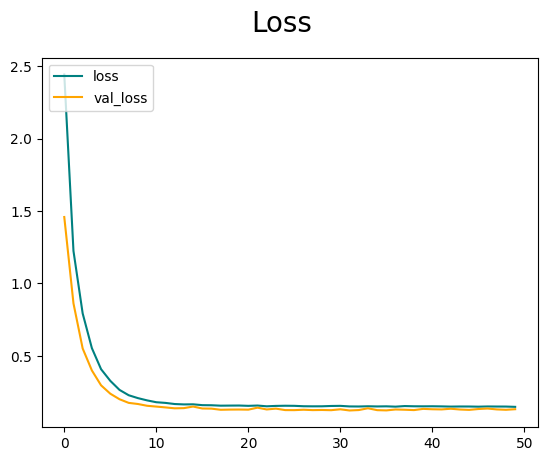

In [13]:
# Plot performance

fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [14]:
# Evaluate

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")



47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 0.1303 - mean_absolute_error: 0.2284
Test Loss: 0.13152684271335602
Test MAE: 0.22867067158222198


In [15]:
# Predict on the test set
y_pred = model.predict(X_test)
# Decode the predicted labels back to original ratings
y_pred_labels = ordinal_encoder.inverse_transform(y_pred)

# Decode the actual labels
y_test_labels = ordinal_encoder.inverse_transform(y_test.reshape(-1, 1))

# Display some of the predictions and actual values
predictions_df = pd.DataFrame({
    'Actual': y_test_labels.flatten(),
    'Predicted': y_pred_labels.flatten()
})

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [16]:
print(predictions_df.tail(30))


     Actual Predicted
1470     Ba         B
1471    Caa        Ca
1472    Caa        Ca
1473     Ba         B
1474      B         B
1475      B       Caa
1476    Baa        Ba
1477    Caa        Ca
1478    Caa       Caa
1479    Caa        Ca
1480      B         B
1481      B         B
1482     Ba         B
1483     Ba         B
1484      B         B
1485      B       Caa
1486     Ba         B
1487      B         B
1488     Ba         B
1489     Ba        Ba
1490      B       Caa
1491    Caa        Ca
1492    Caa       Caa
1493      B       Caa
1494    Caa       Caa
1495      B       Caa
1496     Ba         B
1497     Ba         B
1498      B       Caa
1499      B       Caa


In [26]:
# Calculate the accuracy of the predictions with a tolerance of one rating level
def calculate_accuracy_with_tolerance(y_true, y_pred, tolerance=1):
    correct_predictions = np.sum(np.abs(y_true - y_pred) <= tolerance)
    total_predictions = len(y_true)
    accuracy = correct_predictions / total_predictions
    return correct_predictions, total_predictions, accuracy

# Convert ratings back to their ordinal values for comparison
y_test_ordinal = ordinal_encoder.transform(y_test_labels.reshape(-1, 1)).flatten()
y_pred_ordinal = ordinal_encoder.transform(y_pred_labels.reshape(-1, 1)).flatten()

# Calculate accuracy with tolerance
correct_predictions, total_predictions, accuracy = calculate_accuracy_with_tolerance(y_test_ordinal, y_pred_ordinal)

print(f"Correct Predictions within tolerance: {correct_predictions}")
print(f"Total Predictions: {total_predictions}")
print(f"Accuracy within tolerance: {accuracy * 100:.2f}%")


Correct Predictions within tolerance: 1500
Total Predictions: 1500
Accuracy within tolerance: 100.00%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(


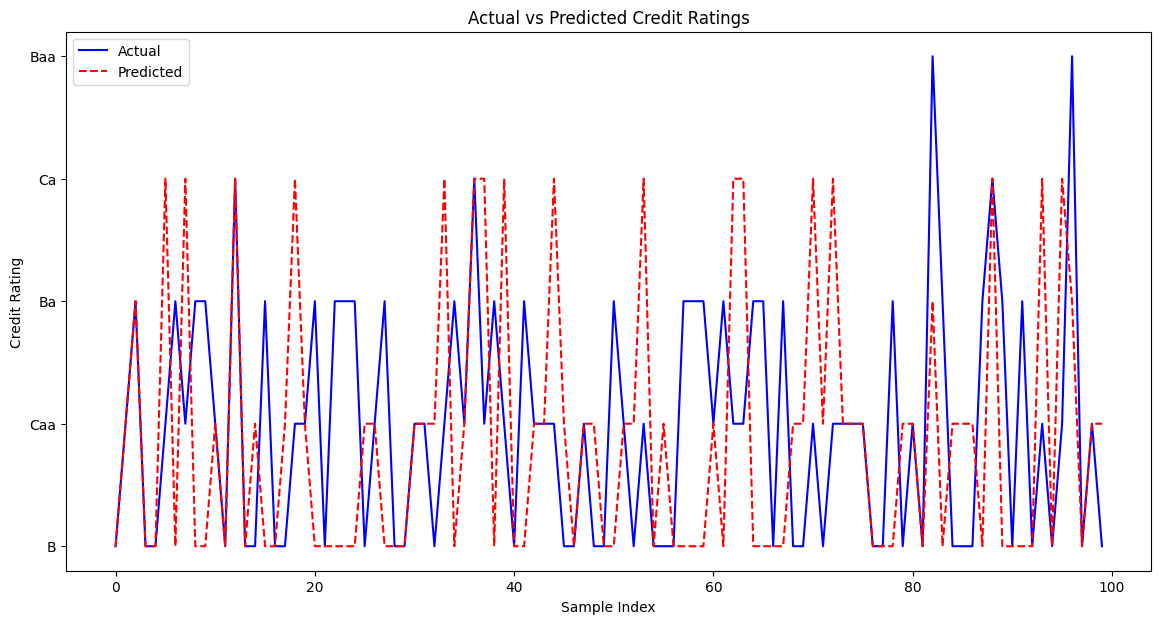

In [17]:

# Ensure that y_test_labels and y_pred_labels are in the correct shape
y_test_labels = y_test_labels.flatten()
y_pred_labels = y_pred_labels.flatten()

# Sample subset for better visualization (if the dataset is large)
sample_size = 100  # Adjust this value as needed
indices = np.random.choice(len(y_test_labels), sample_size, replace=False)

# Subset the data for plotting
y_test_sample = y_test_labels[indices]
y_pred_sample = y_pred_labels[indices]

plt.figure(figsize=(14, 7))
plt.plot(range(len(y_test_sample)), y_test_sample, color='blue', label='Actual')
plt.plot(range(len(y_test_sample)), y_pred_sample, color='red', linestyle='--', label='Predicted')
plt.title('Actual vs Predicted Credit Ratings')
plt.xlabel('Sample Index')
plt.ylabel('Credit Rating')
plt.legend()
plt.show()

